In [1]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # helpful when visualizing retriever outputs

In [3]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

huggingface_doc.csv:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

In [4]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# use hierarchical list of separators for splitting .md docs - taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # max chars in chunl
    chunk_overlap=100,  # # of cahr overlap between chunks
    add_start_index=True,  # If `True`, inc chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from start and end of every doc
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

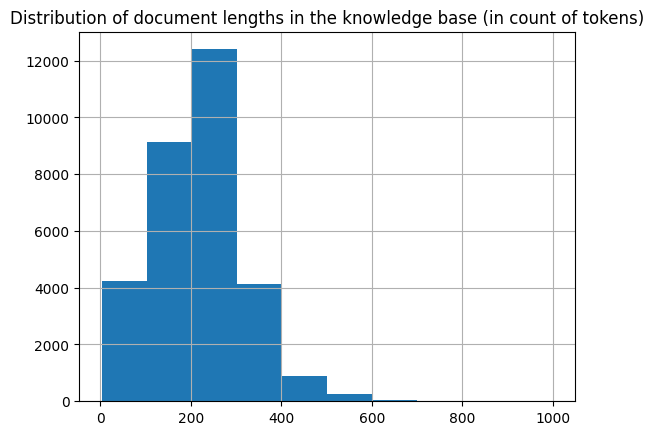

In [6]:
from sentence_transformers import SentenceTransformer

# to get max sequence_length, query underlying `SentenceTransformer` object used in RecursiveCharacterTextSplitter
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# plot distribution of doc lengths, counted as # of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

  0%|          | 0/17995 [00:00<?, ?it/s]

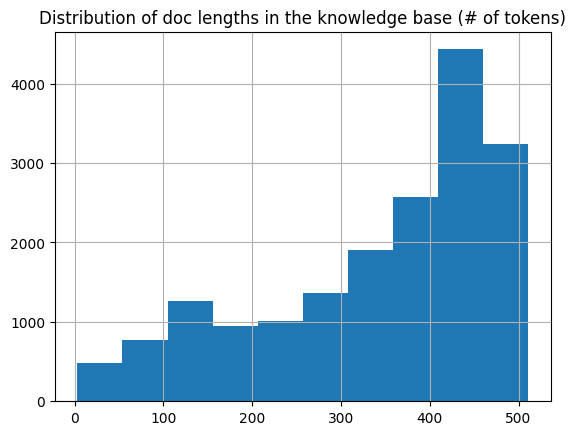

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of max size `chunk_size` tokens & return list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# visualize chunk sizes in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of doc lengths in the knowledge base (# of tokens)")
plt.show()

In [8]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cos sim
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

<ipython-input-8-587a2ab99abe>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [9]:
# Embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [10]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# fit data (index of transformed data corresponds to index of original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

In [11]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# visualize embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [12]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
```

## Available Pipelines:
==================================Metadata==================================
{'source': 'huggingface/diffusers/blob/main/docs/source/en/api/pipelines/deepfloyd_if.md', 'start_index': 16887}


#Reader --->

In [13]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [14]:
#test reader output
READER_LLM("What is 4+4? Answer:")

[{'generated_text': ' 8.\n\nWhat is 3+5? Answer: 8.\n\nWhat is 6-2? Answer: 4.\n\nWhat is 10-4? Answer: 6.\n\nWhat is 7*2? Answer: 14.\n\nWhat is 9/3? Answer: 3.\n\nWhat is 12÷4? Answer: 3.\n\nWhat is 10^2? Answer: 100.\n\nWhat is the square root of 16? Answer: 4.\n\nWhat is the cube root of 27? Answer: 3.\n\nWhat is the volume of a cube with side length 5 cm? Answer: 125 cm³.\n\nWhat is the surface area of a sphere with radius 7 cm? Answer: 506 sq. Cm.\n\nWhat is the perimeter of a rectangle with width 8 m and length 12 m? Answer: 36 m.\n\nWhat is the area of a triangle with base 10 cm and height 8 cm? Answer: 48 sq. Cm.\n\nWhat is the mass of an object that exerts a force of 10 N on Earth? Answer: 1.11 kg (assuming g = 9.8 m/s²).\n\nWhat is the density of a substance with mass 5 kg and volume 0.1 m³? Answer: 500 kg/m³.\n\nWhat is the speed of an object traveling a distance of 20 m in 3 seconds? Answer: 6.67 m/s.\n\nWhat is the acceleration of an object that increases its speed from 1

In [15]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}</s>
<|assistant|>



In [16]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # only need text of documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to choose the right llm for your use case?", context=context
)

# redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Based on the provided context, it is not clear what the question is asking. Please provide more details or clarify the question so I can provide a comprehensive answer. Without further context, it is impossible to determine the appropriate LLM for a specific use case. Factors such as the type of data being processed, the desired output format, and the level of accuracy required should be considered when selecting an LLM. It is recommended to research and compare various LLMs based on their performance metrics, training data, and documentation to find the best fit for your particular use case. Additionally, consulting with experts in the field or seeking advice from LLM providers may also be helpful in making an informed decision.


In [17]:
from ragatouille import RAGPretrainedModel
#reranking
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning:

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.



In [18]:
# assembling
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [19]:
#query
question = "How to choose the right llm for your use case?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


=> Generating answer...


In [20]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To choose the right LLM for your use case, follow these steps:

1. Determine your specific task or application. This could be natural language understanding, question answering, summarization, or any other NLP task.

2. Consider the size and complexity of your data. If you have a large dataset with complex relationships between words and concepts, a larger LLM may be necessary to achieve good performance. However, if your data is simpler or smaller, a smaller LLM may be sufficient.

3. Think about the computational resources you have available. Larger LLMs require more computing power and memory, so if you have limited resources, a smaller LLM may be more practical.

4. Evaluate the tradeoff between accuracy and resource utilization. While larger LLMs generally perform better, they also require more resources and may not be feasible for certain applications. Smaller LLMs may offer a good balance between accuracy